In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations

In [2]:
# Define column names (since the dataset doesn't include headers)
column_names = ["Feature 0", "Feature 1", "Feature 2", "Feature 3", "Species"]

url = "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
df = pd.read_csv(url, names=column_names)

# Display the first few rows
#print(df.head(50))

In [8]:
species_list = ["Setosa", "Versicolor", "Virginica"]
features_list = ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']
train_list, test_list = [], []

for species in species_list:
    species_data = df[df["Species"] == species]
    X_species = species_data[['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']].values
    y_species = species_data['Species'].values  # If you need labels
    
    # 80-20 split for each species
    X_train, X_test, y_train, y_test = train_test_split(
        X_species, y_species, test_size=0.6, random_state=42, stratify=y_species
    )

    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))

# Combine the train and test data
X_train = np.vstack([t[0] for t in train_list])
y_train = np.hstack([t[1] for t in train_list])

X_test = np.vstack([t[0] for t in test_list])
y_test = np.hstack([t[1] for t in test_list])

# print(X_test)
# print(y_test)

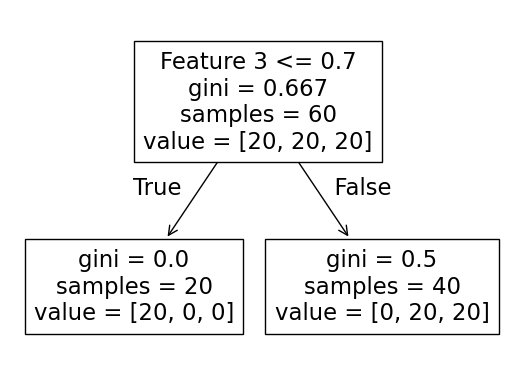

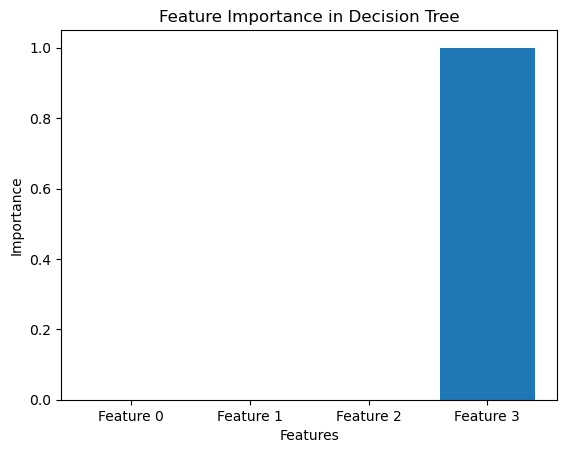

In [9]:
weak_learner = DecisionTreeClassifier(max_leaf_nodes=2)
dtree = weak_learner.fit(X_train, y_train)

#Plot tree
tree.plot_tree(dtree, feature_names=features_list)
plt.savefig("tree.png")
plt.show()

#checking why Feature 0 and Feature 1 are not used
feature_importance = dtree.feature_importances_ 
plt.bar(features_list, feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.show()

In [5]:
n_estimators = 200
adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    algorithm ='SAMME',
    n_estimators=n_estimators,
    random_state=42,
).fit(X_train, y_train)  #learning_rate=1.0

In [6]:
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, dtree.predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.333


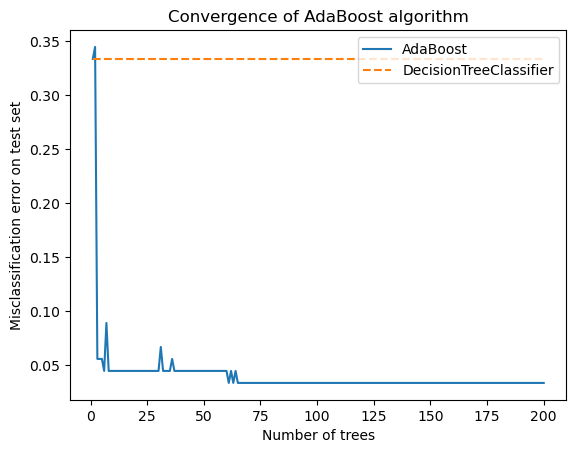

In [7]:
boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators+1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)

plt.legend(["AdaBoost", "DecisionTreeClassifier"], loc=1)
plt.savefig("convergence.png")
plt.show()

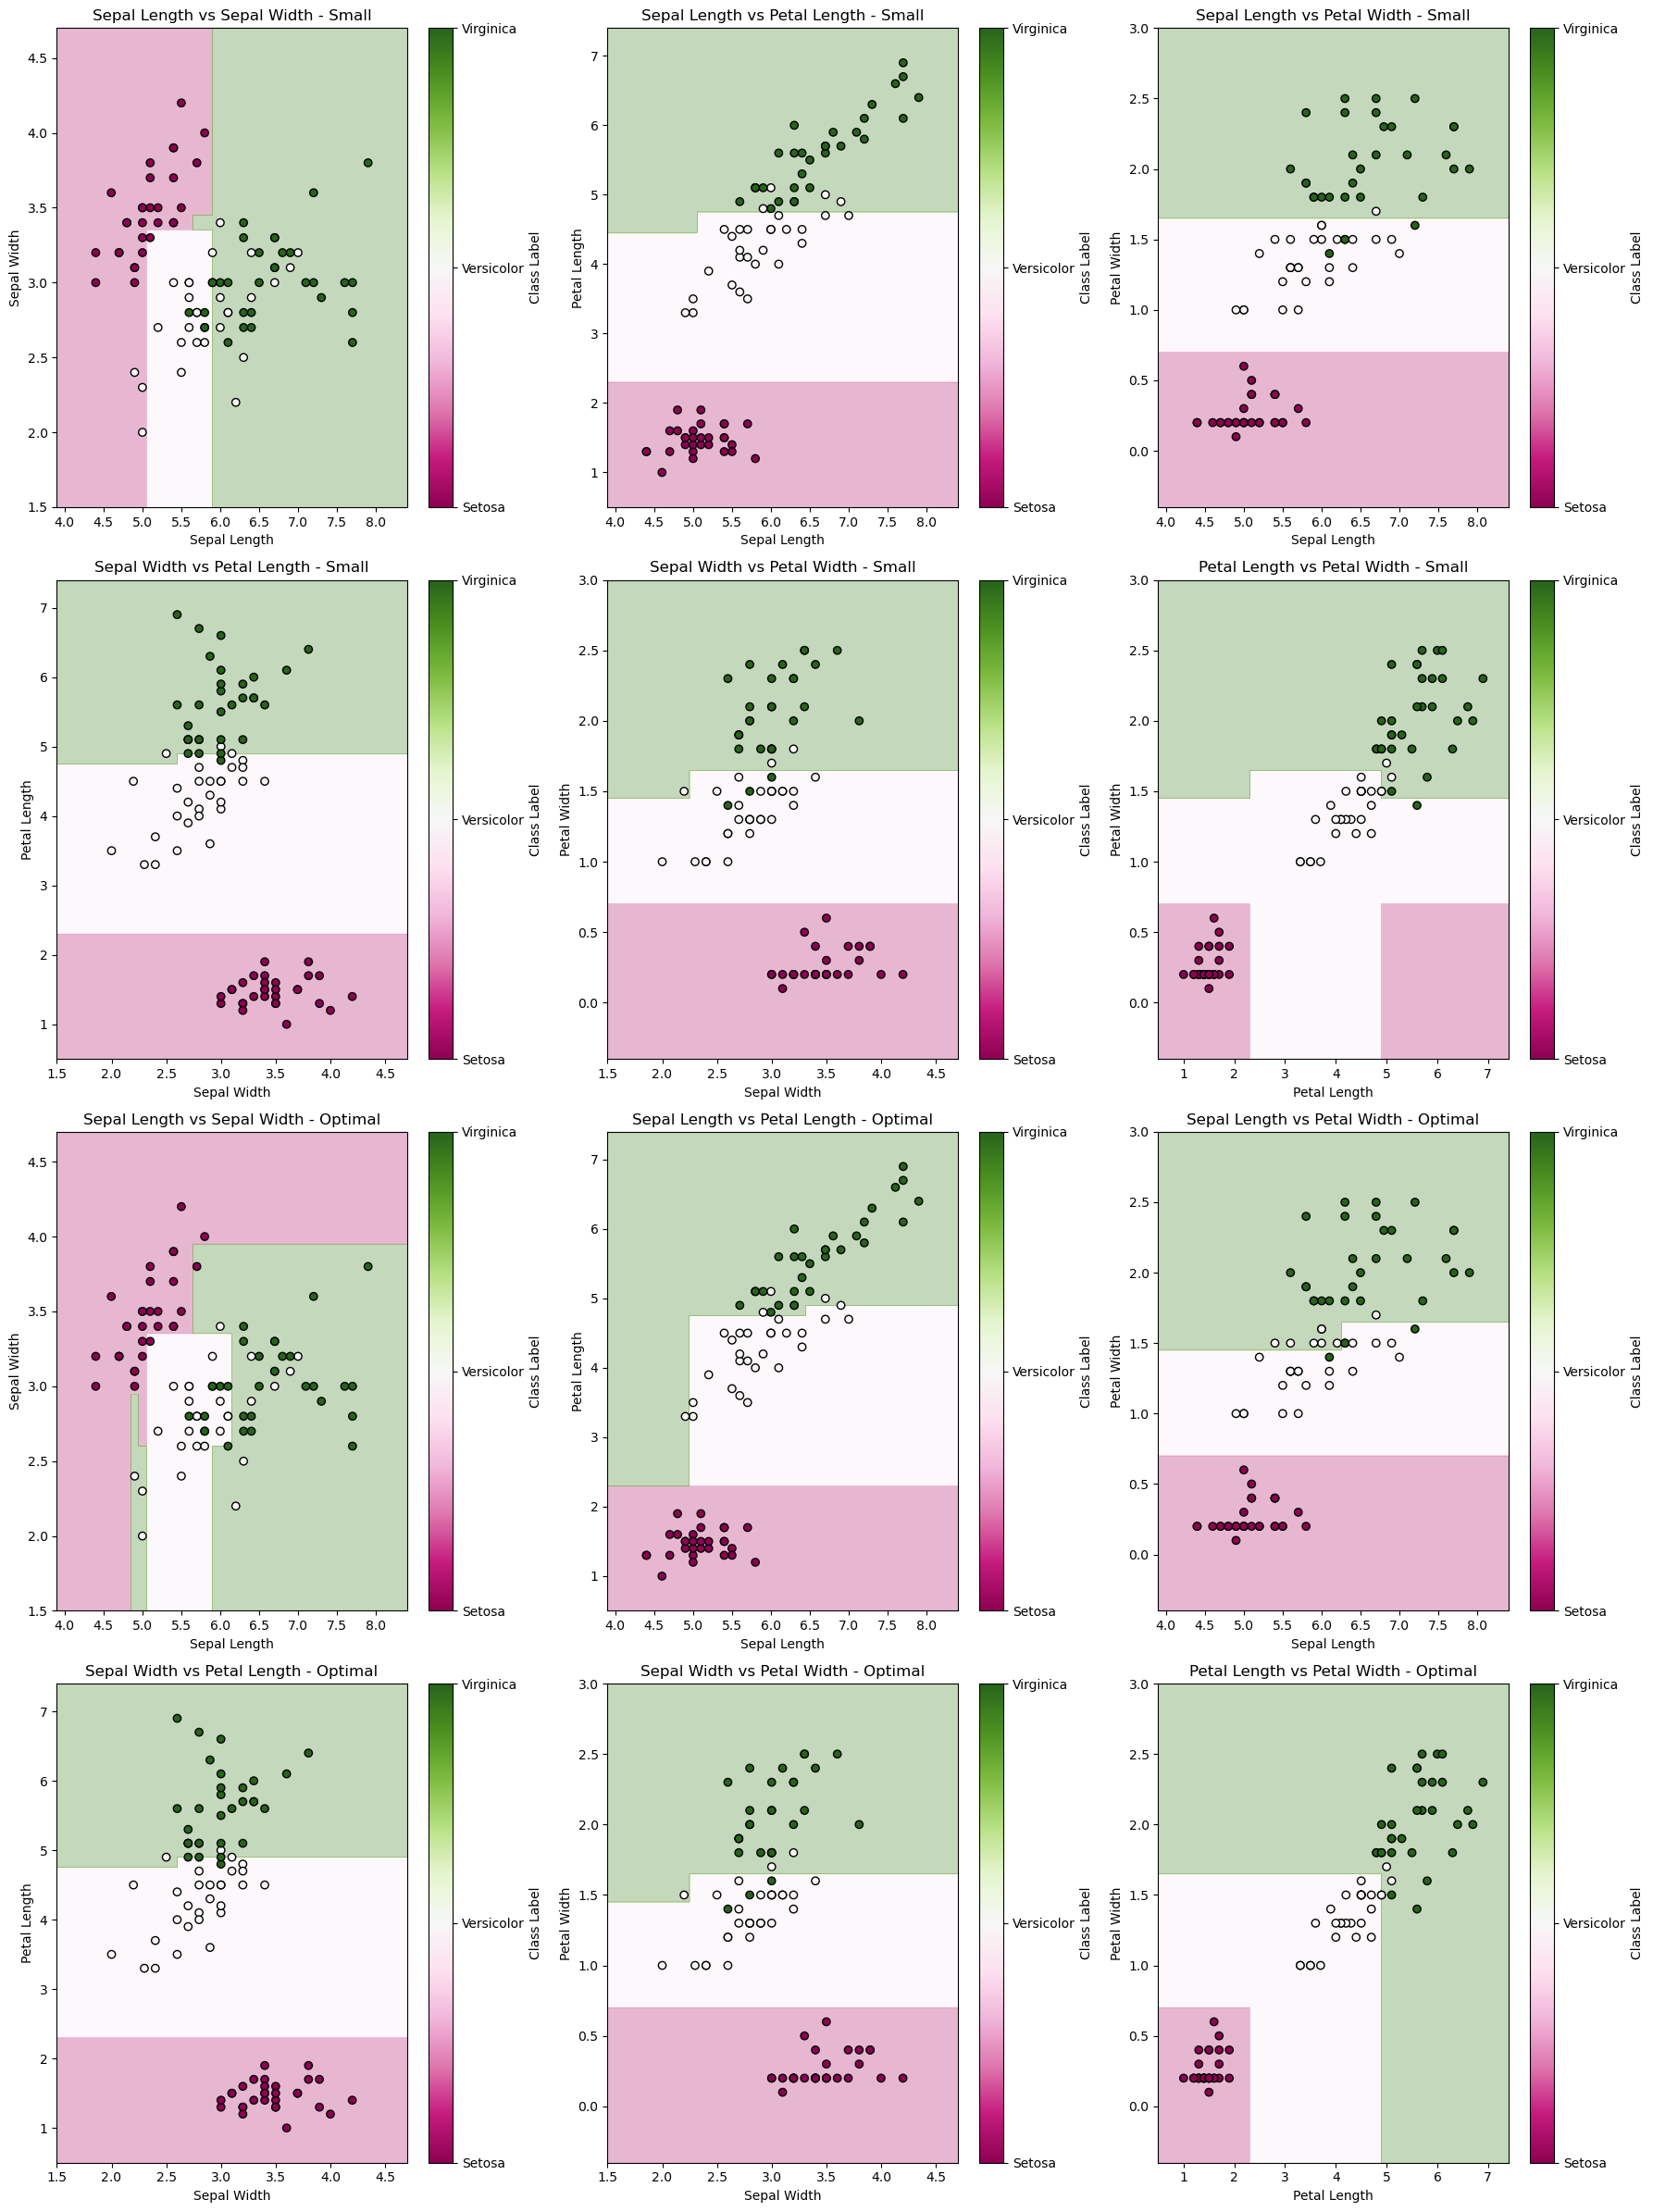

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on the training labels (y_train)
label_encoder.fit(y_train)

# Convert class labels to numeric values
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

# Define feature pairs
feature_pairs = list(combinations(range(4), 2))

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, feature_idx, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 750),
                         np.linspace(y_min, y_max, 750))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #print("Printing Z: \n", Z)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.PiYG)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y_test_encoded, edgecolor='k', cmap=plt.cm.PiYG)

    # Add a color bar with class labels
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_ticks([0, 1, 2])  # Set the tick marks to correspond to class indices
    cbar.set_ticklabels(label_encoder.classes_)  # Set the tick labels to be the class names
    cbar.set_label('Class Label')
    
    ax.set_xlabel(feature_names[feature_idx[0]])
    ax.set_ylabel(feature_names[feature_idx[1]])
    ax.set_title(title)
    
# Create plots for both models
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.ravel()

for i, pair in enumerate(feature_pairs):
    # Select two features
    X_train_subset = X_train[:, pair]
    X_test_subset = X_test[:, pair]

    X_train_subset = X_train[:, pair].astype(float)
    X_test_subset = X_test[:, pair].astype(float)

    # Train models on the two selected features
    model_small = AdaBoostClassifier(estimator=weak_learner, algorithm = 'SAMME', n_estimators=10, random_state=42)
    model_optimal = AdaBoostClassifier(estimator=weak_learner, algorithm = 'SAMME', n_estimators=200, random_state=42)
    
    model_small.fit(X_train_subset, y_train_encoded)
    model_optimal.fit(X_train_subset, y_train_encoded)

    # Plot decision boundaries
    plot_decision_boundary(model_small, X_test_subset, y_test, pair, f"{feature_names[pair[0]]} vs {feature_names[pair[1]]} - Small", axes[i])
    plot_decision_boundary(model_optimal, X_test_subset, y_test, pair, f"{feature_names[pair[0]]} vs {feature_names[pair[1]]} - Optimal", axes[i+6])

plt.tight_layout()
plt.savefig("adaboost.png")
plt.show()

# print(feature_pairs)
# print(X_train_subset)

# Changing the number of estimator

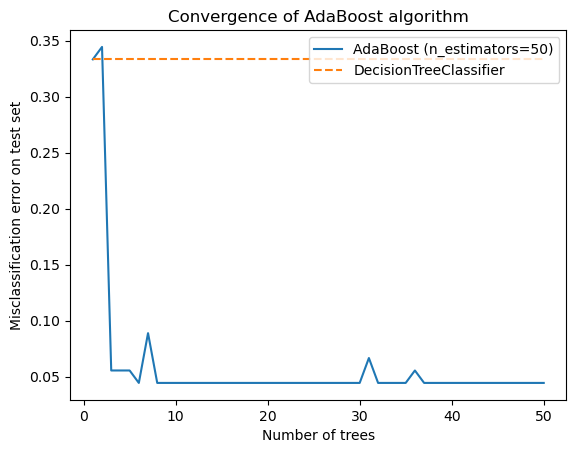

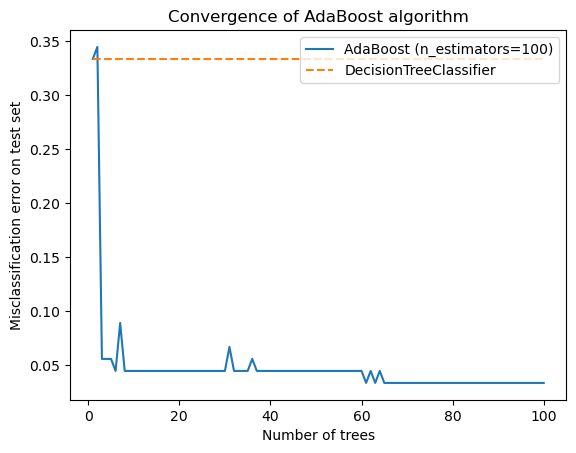

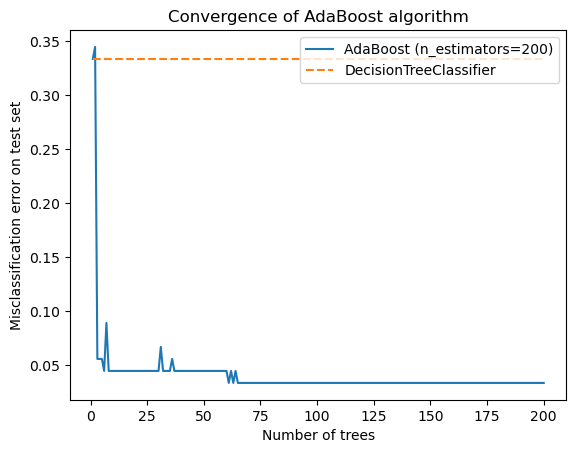

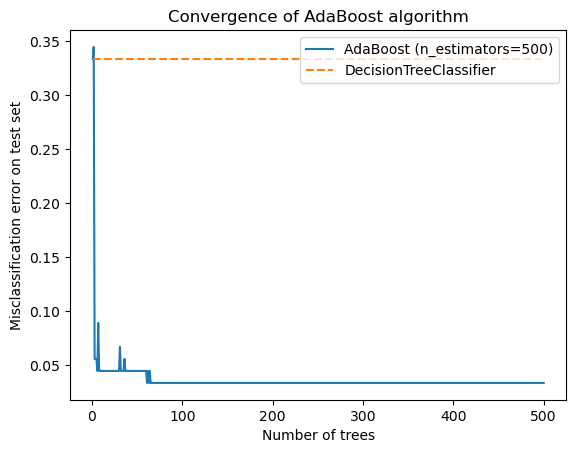

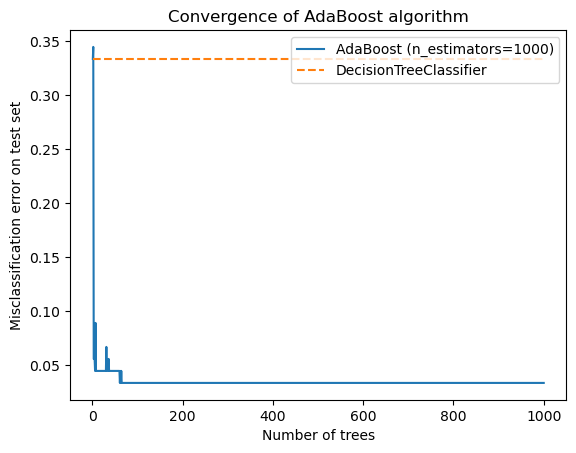

In [9]:
n_estimators = [50, 100, 200, 500, 1000]

for n, value in enumerate(n_estimators):
    
    adaboost_clf = AdaBoostClassifier(
        estimator=weak_learner,
        algorithm ='SAMME',
        n_estimators=value,
        random_state=42,
    ).fit(X_train, y_train)
    boosting_errors = pd.DataFrame(
        {
            "Number of trees": range(1, value+1),
            "AdaBoost": [
                misclassification_error(y_test, y_pred)
                for y_pred in adaboost_clf.staged_predict(X_test)
            ],
        }
    ).set_index("Number of trees")
    ax = boosting_errors.plot()
    ax.set_ylabel("Misclassification error on test set")
    ax.set_title("Convergence of AdaBoost algorithm")
    
    plt.plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [weak_learners_misclassification_error, weak_learners_misclassification_error],
        color="tab:orange",
        linestyle="dashed",
    )
    
    plt.legend([f"AdaBoost (n_estimators={value})", "DecisionTreeClassifier"],  loc=1)
    if value == 50 or value == 200:
        plt.savefig(f"convergence_{value}.png")
    plt.show()    

# Variation of learning rate

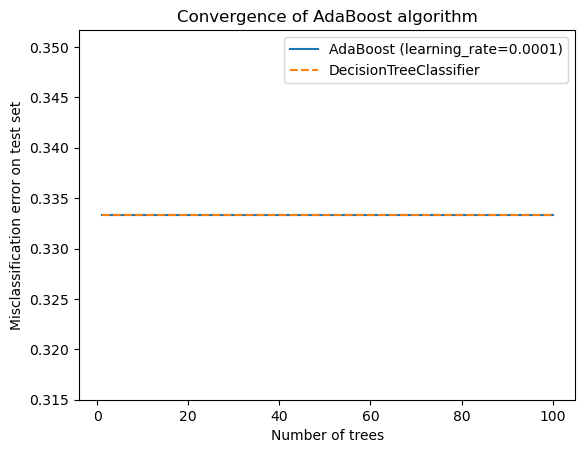

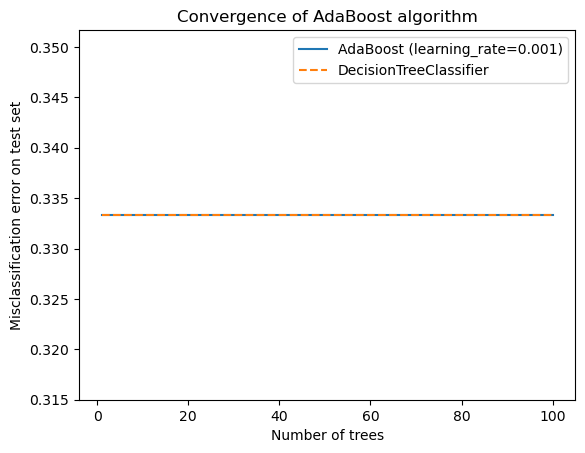

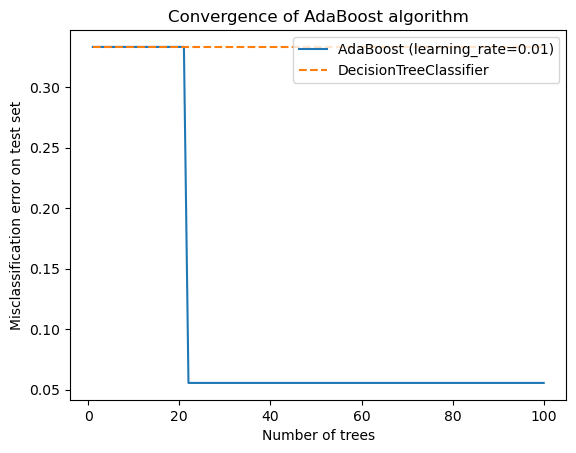

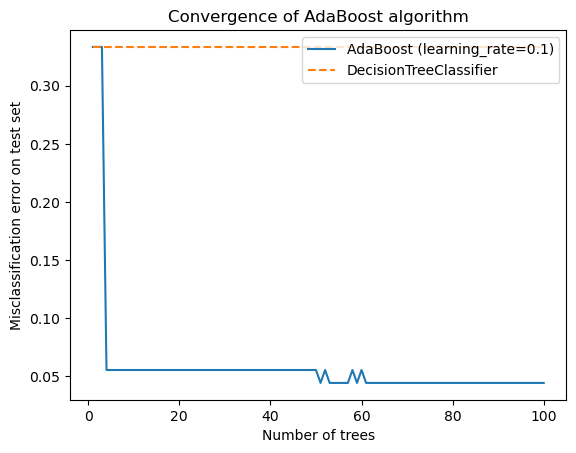

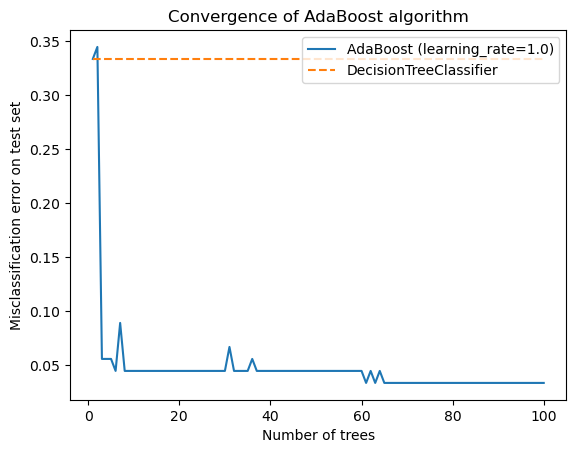

In [10]:
n_estimators = 100
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

for i, value in enumerate(learning_rate):
    
    adaboost_clf = AdaBoostClassifier(
        estimator=weak_learner,
        algorithm ='SAMME',
        n_estimators=n_estimators,
        learning_rate=value,
        random_state=42,
    ).fit(X_train, y_train)
    boosting_errors = pd.DataFrame(
        {
            "Number of trees": range(1, n_estimators+1),
            "AdaBoost": [
                misclassification_error(y_test, y_pred)
                for y_pred in adaboost_clf.staged_predict(X_test)
            ],
        }
    ).set_index("Number of trees")
    ax = boosting_errors.plot()
    ax.set_ylabel("Misclassification error on test set")
    ax.set_title("Convergence of AdaBoost algorithm")
    
    plt.plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [weak_learners_misclassification_error, weak_learners_misclassification_error],
        color="tab:orange",
        linestyle="dashed",
    )
    
    plt.legend([f"AdaBoost (learning_rate={value})", "DecisionTreeClassifier"],  loc=1)
    if value == 0.0001 or value == 1.0:
        plt.savefig(f"convergence_{value}.png")
    plt.show()    

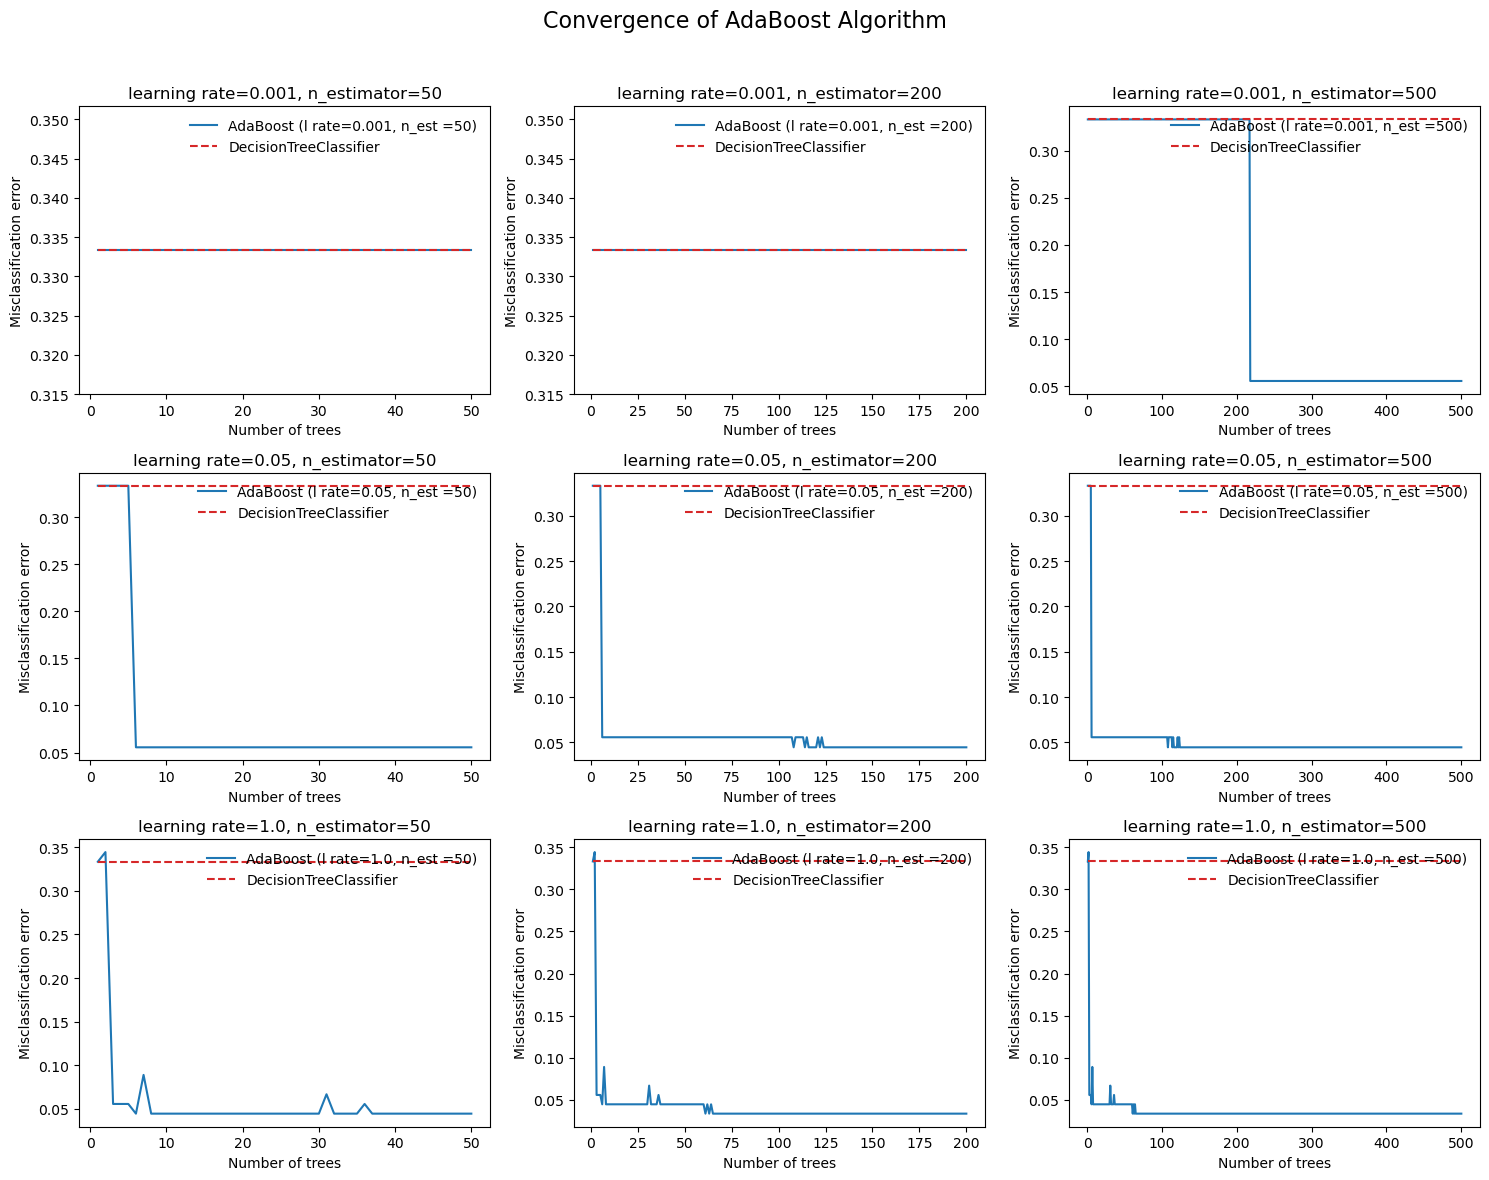

In [18]:
n_estimators = [50, 200, 500]
learning_rate = [0.001, 0.05, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Convergence of AdaBoost Algorithm", fontsize=16)

for i, value in enumerate(learning_rate):
    for j, value_j in enumerate(n_estimators):
        ax = axes[i, j]  # Select the appropriate subplot
        
        adaboost_clf = AdaBoostClassifier(
            estimator=weak_learner,
            algorithm='SAMME',
            n_estimators=value_j,
            learning_rate=value,
            random_state=42,
        ).fit(X_train, y_train)
        
        boosting_errors = pd.DataFrame(
            {
                "Number of trees": range(1, value_j + 1),
                "AdaBoost": [
                    misclassification_error(y_test, y_pred)
                    for y_pred in adaboost_clf.staged_predict(X_test)
                ],
            }
        ).set_index("Number of trees")
        
        boosting_errors.plot(ax=ax)
        ax.set_ylabel("Misclassification error")
        ax.set_xlabel("Number of trees")
        ax.set_title(f"learning rate={value}, n_estimator={value_j}")
        
        ax.plot(
            [boosting_errors.index.min(), boosting_errors.index.max()],
            [weak_learners_misclassification_error, weak_learners_misclassification_error],
            color="tab:red",
            linestyle="dashed",
        )
        
        ax.legend([
            f"AdaBoost (l rate={value}, n_est ={value_j})", "DecisionTreeClassifier"
        ], loc=1, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()